In [18]:
import pandas as pd
import numpy as np
pd.set_option("display.width", 200)
pd.set_option('display.float_format', '{:.4f}'.format)

from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [19]:
data = pd.read_csv("data/SupplyChainRiskOptSimData.csv")
data.head()

,Product type,SKU,Production Date,Shipping Date,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,...,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs,Shortage Risk,Actual Shipping Time,Delay
0,haircare,SKU0,2023-10-06,2023-10-08,69.8080,0.8928,84,8661.9968,Non-binary,68,...,29,46.2799,Pending,0.2264,Road,Route B,187.7521,True,2,-5
1,skincare,SKU1,2025-01-04,2025-01-31,14.8435,0.8173,30,7460.9001,Female,24,...,30,33.6168,Pending,4.8541,Road,Route B,503.0656,True,27,-3
2,haircare,SKU2,2023-05-26,2023-05-30,11.3197,0.8640,93,9577.7496,Unknown,80,...,27,30.6880,Pending,4.5806,Air,Route C,141.9203,True,4,-6
3,skincare,SKU3,2024-09-27,2024-10-13,61.1633,0.8540,79,7766.8364,Non-binary,71,...,18,35.6247,Fail,4.7466,Rail,Route A,254.7762,True,16,3
4,skincare,SKU4,2023-08-19,2023-08-17,4.8055,0.9502,75,2686.5052,Non-binary,97,...,3,92.0652,Fail,3.1456,Air,Route A,923.4406,False,-2,-5


In [20]:
data["Production Date"] = pd.to_datetime(data["Production Date"])
data["Shipping Date"] = pd.to_datetime(data["Shipping Date"])

**Risk Assessment**

In [21]:
data['Shortage Risk'] = data['Stock levels'] < data['Number of products sold']

data['Actual Shipping Time'] = (data['Shipping Date'] - data['Production Date']).dt.days

data['Delay'] = data['Actual Shipping Time'] - data['Lead times']

data_sorted = data.sort_values(by = 'Revenue generated', ascending=False)

print("Products with Potential Shortage Risk:")
print(data_sorted[data_sorted['Shortage Risk']][['SKU', 'Stock levels', 'Number of products sold', 'Revenue generated']])
print()
print("Products with Delays:")
print(data_sorted[data_sorted['Delay'] > 0][['SKU', 'Delay', 'Revenue generated']])

Products with Potential Shortage Risk:
          SKU  Stock levels  Number of products sold  Revenue generated
51      SKU51            25                       50          9866.4655
3230  SKU3230            19                       55          9866.1141
2420  SKU2420            19                       30          9863.2929
432    SKU432            59                       78          9862.8873
1504  SKU1504            86                       97          9859.9547
...       ...           ...                      ...                ...
6424  SKU6424            57                       99          1077.9136
7061  SKU7061            23                       29          1073.4350
5256  SKU5256            29                       37          1068.6966
5520  SKU5520            25                       42          1062.6966
59      SKU59            17                       64          1061.6185

[3996 rows x 4 columns]

Products with Delays:
          SKU  Delay  Revenue generated
51      S

In [22]:
data[data["Stock levels"] < data["Number of products sold"]][["SKU", "Stock levels", "Number of products sold", "Revenue generated"]].iloc[:5]

,SKU,Stock levels,Number of products sold,Revenue generated
0,SKU0,68,84,8661.9968
1,SKU1,24,30,7460.9001
2,SKU2,80,93,9577.7496
3,SKU3,71,79,7766.8364
8,SKU8,27,68,7517.3632


In [23]:
data[data["Delay"] > 0][["SKU", "Delay", "Revenue generated"]].head()

,SKU,Delay,Revenue generated
3,SKU3,3,7766.8364
6,SKU6,5,7823.4766
7,SKU7,2,8496.1038
9,SKU9,4,4971.1460
11,SKU11,3,6099.9441


In [24]:
data[data["Delay"] > 0]["Revenue generated"].sum()

16128576.43825475

**Supplier Value Index**

In [25]:
supplier_data = data.groupby("Supplier name").agg({
    'Revenue generated': 'sum',
    'Manufacturing costs': 'sum'
}).reset_index()

max_revenue = supplier_data['Revenue generated'].max()

supplier_data['Importance'] = supplier_data['Revenue generated'] / max_revenue
supplier_data['Performance'] = (supplier_data['Revenue generated'] - supplier_data['Manufacturing costs']) / max_revenue

supplier_data['Value Index'] = (supplier_data['Importance'] + supplier_data['Performance']) / 2

print("Supplier Value Index Calculation:")
print(supplier_data[['Supplier name', 'Revenue generated', 'Manufacturing costs', 'Importance', 'Performance', 'Value Index']])

Supplier Value Index Calculation:
  Supplier name  Revenue generated  Manufacturing costs  Importance  Performance  Value Index
0    Supplier 1       8431149.5592           74467.4776      1.0000       0.9912       0.9956
1    Supplier 2       7901850.6267           71281.9788      0.9372       0.9288       0.9330
2    Supplier 3       7815963.7607           74133.7210      0.9270       0.9182       0.9226
3    Supplier 4       8151449.5636           77313.0077      0.9668       0.9577       0.9622
4    Supplier 5       7817573.5629           71221.8637      0.9272       0.9188       0.9230


**Products Out of Stock**

In [26]:
data['At Risk'] = data['Availability'] < 0.8
at_risk_items = data[data['At Risk']]
print(f"Products at Risk of Running Out: {len(at_risk_items)}")
print(at_risk_items[['SKU', 'Stock levels', 'Availability']])

Products at Risk of Running Out: 181
          SKU  Stock levels  Availability
22      SKU22            70        0.7924
107    SKU107            86        0.7897
157    SKU157            20        0.7978
225    SKU225            37        0.7753
268    SKU268            73        0.7705
...       ...           ...           ...
7114  SKU7114            78        0.7773
7142  SKU7142            87        0.7772
7201  SKU7201            93        0.7878
7203  SKU7203            98        0.7395
7315  SKU7315            76        0.7931

[181 rows x 3 columns]


In [27]:
at_risk_items[['SKU', 'Stock levels', 'Availability', "Revenue generated"]]

,SKU,Stock levels,Availability,Revenue generated
22,SKU22,70,0.7924,2390.8079
107,SKU107,86,0.7897,9417.2152
157,SKU157,20,0.7978,5696.8164
225,SKU225,37,0.7753,3076.0145
268,SKU268,73,0.7705,9559.7790
...,...,...,...,...
7114,SKU7114,78,0.7773,3176.0912
7142,SKU7142,87,0.7772,5377.3247
7201,SKU7201,93,0.7878,8927.0790
7203,SKU7203,98,0.7395,8193.6627


In [28]:
at_risk_items.shape[0]/data.shape[0] * 100

2.4713271436373567

In [29]:
data.loc[at_risk_items.index, "Revenue generated"].sum()

1073753.655309447

**Demand Forecasting**

In [30]:
daily_sales = data.groupby('Production Date').agg({
    'Number of products sold': 'sum',
    'Revenue generated': 'sum'
}).reset_index()
daily_sales

,Production Date,Number of products sold,Revenue generated
0,2023-03-06,710,74508.6197
1,2023-03-07,860,92020.3237
2,2023-03-08,386,33546.1966
3,2023-03-09,926,89298.6564
4,2023-03-10,538,54661.1885
...,...,...,...
717,2025-02-20,23,7528.3414
718,2025-02-21,142,16680.4203
719,2025-02-22,138,6374.9127
720,2025-02-23,120,11307.4138


In [31]:
x = list(daily_sales["Number of products sold"])
temp = 0
while temp < 30:
    x.append(sum(x[-30:])/30)
    temp += 1

for i in range(30):
    daily_sales.loc[i + daily_sales.shape[0], "Production Date"] = daily_sales.loc[721, "Production Date"] + timedelta(days =  i)

daily_sales["Number of products sold"] = x

daily_sales[["Production Date", "Number of products sold"]].tail(30)

,Production Date,Number of products sold
722,2025-02-28,378.8667
724,2025-03-01,368.0289
726,2025-03-02,361.2965
728,2025-03-03,354.6397
730,2025-03-04,350.7277
732,2025-03-05,338.6520
734,2025-03-06,332.2737
736,2025-03-07,323.4162
738,2025-03-08,316.5634
740,2025-03-09,302.3822


In [32]:
daily_sales.iloc[:-30, 0]

0     2023-03-06
1     2023-03-07
2     2023-03-08
3     2023-03-09
4     2023-03-10
         ...    
717   2025-02-20
718   2025-02-21
719   2025-02-22
720   2025-02-23
721   2025-02-28
Name: Production Date, Length: 722, dtype: datetime64[ns]

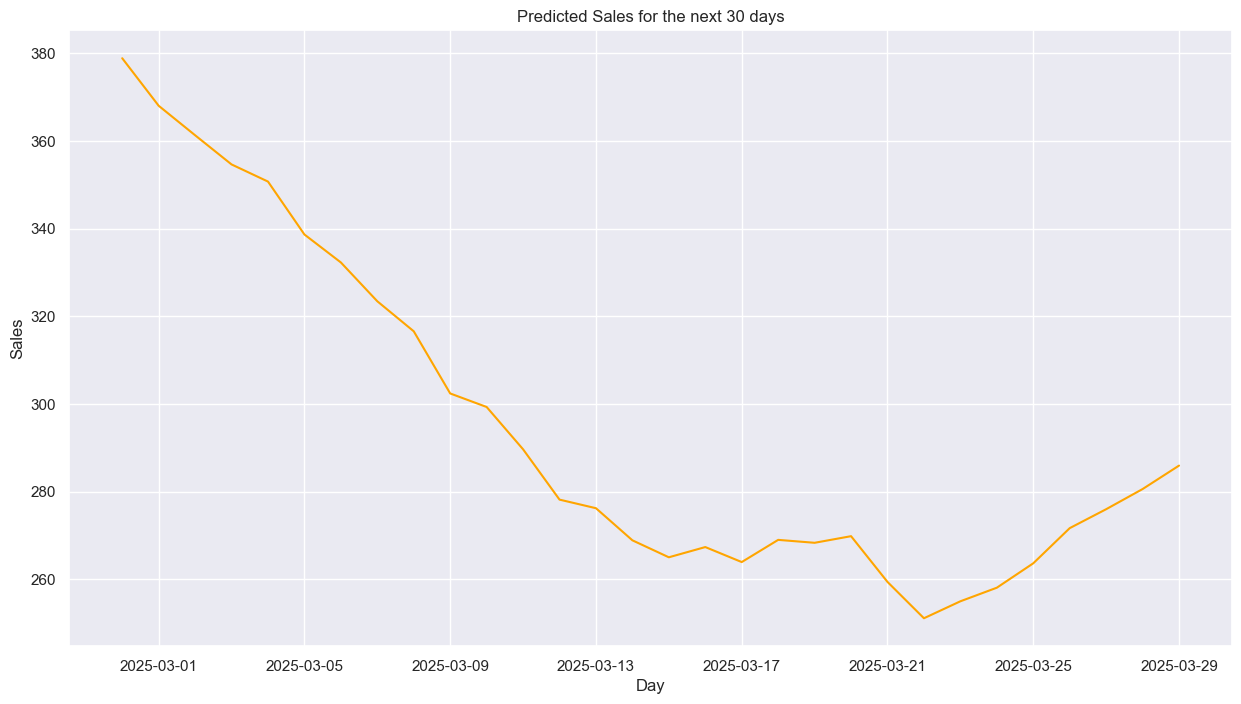

In [33]:
plt.figure(figsize = [15,8])
plt.plot(daily_sales.iloc[-30:, 0], daily_sales.iloc[-30:, 1], color = "orange")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Predicted Sales for the next 30 days")
plt.show()

**Demand Forecasting by Region**

In [34]:
demo_sales = data.groupby(['Production Date', 'Location']).agg({
    'Number of products sold': 'sum'
}).reset_index()
demo_sales

,Production Date,Location,Number of products sold
0,2023-03-06,Bangalore,81
1,2023-03-06,Chennai,156
2,2023-03-06,Delhi,159
3,2023-03-06,Kolkata,94
4,2023-03-06,Mumbai,220
...,...,...,...
3119,2025-02-22,Bangalore,96
3120,2025-02-22,Kolkata,42
3121,2025-02-23,Bangalore,48
3122,2025-02-23,Delhi,72


In [35]:
demo_pivot = demo_sales.pivot(index = 'Production Date', columns = 'Location', values = 'Number of products sold').fillna(0)
print("Demand by Region Sample:")
demo_pivot

Demand by Region Sample:


Location,Bangalore,Chennai,Delhi,Kolkata,Mumbai
Production Date,,,,,
2023-03-06,81.0000,156.0000,159.0000,94.0000,220.0000
2023-03-07,225.0000,110.0000,232.0000,54.0000,239.0000
2023-03-08,89.0000,37.0000,93.0000,116.0000,51.0000
2023-03-09,132.0000,131.0000,109.0000,200.0000,354.0000
2023-03-10,140.0000,131.0000,77.0000,91.0000,99.0000
...,...,...,...,...,...
2025-02-20,0.0000,0.0000,0.0000,0.0000,23.0000
2025-02-21,0.0000,0.0000,0.0000,0.0000,142.0000
2025-02-22,96.0000,0.0000,0.0000,42.0000,0.0000


In [36]:
forecasted_values = []
for i in demo_pivot.columns:
    val, lst = 0, list(demo_pivot[i])
    while val < 30:
        lst.append(sum(lst[-30:]) / 30)
        val += 1
    forecasted_values.append(lst[-30:])

forecasted_data = pd.DataFrame(index = pd.date_range(start = '2025-03-01', end = '2025-03-30', freq = 'D'), columns = demo_pivot.columns)

for i, j in zip(forecasted_values, forecasted_data):
    forecasted_data[j] = i

forecasted_data

Location,Bangalore,Chennai,Delhi,Kolkata,Mumbai
2025-03-01,95.9000,72.0000,46.5667,80.2000,84.2000
2025-03-02,88.6633,73.3333,43.8189,79.7733,82.4400
2025-03-03,91.6188,67.4111,40.5462,77.6991,84.0213
2025-03-04,85.5061,64.0915,38.8977,80.2891,85.8554
2025-03-05,88.3563,59.0279,40.1943,80.4321,82.7172
2025-03-06,83.0681,58.3288,41.5341,81.8465,73.8745
2025-03-07,83.1704,57.4064,39.8186,80.1413,71.7369
2025-03-08,81.4094,58.2200,37.9126,76.1794,69.6948
2025-03-09,82.2231,56.8273,39.1763,76.7520,61.5847
2025-03-10,78.4972,51.8215,40.4822,67.9438,63.6375


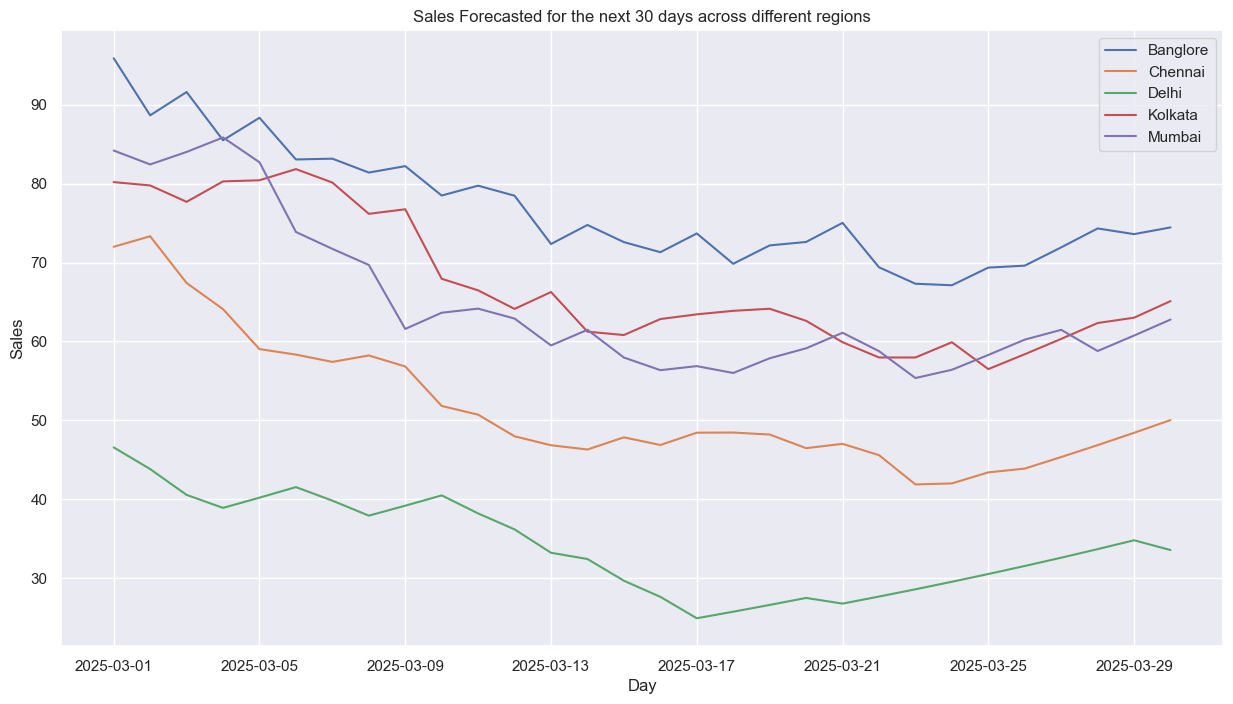

In [37]:
plt.figure(figsize = [15,8])
plt.plot(forecasted_data["Bangalore"], label = "Banglore")
plt.plot(forecasted_data["Chennai"], label = "Chennai")
plt.plot(forecasted_data["Delhi"], label = "Delhi")
plt.plot(forecasted_data["Kolkata"], label = "Kolkata")
plt.plot(forecasted_data["Mumbai"], label = "Mumbai")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Sales Forecasted for the next 30 days across different regions")
plt.legend()
plt.show()